# Model Evaluation
This notebook contains steps for evaluating models to predict the percentage increase in Queens.  
The step I'll take it as below ...
1. Compare the total RMSE (sum of all 5 zipcodes) based on rolling forecast between models
2. Using the best model, forecast for the future terms
3. Find the zipcode with the most increase

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import seaborn as sns

import pickle

from SCRIPT.eval_tools import *

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
with open('PKL/timeseries_queens_p.pkl', 'rb') as fp:
    df = pickle.load(fp)

In [4]:
df.index = pd.DatetimeIndex(df.index.values, freq='infer')

In [5]:
df.columns = df.columns.astype(str)

In [6]:
trdf = df.iloc[:-40]

For the initial univariate modeling, I will compare the top 5 zipcodes with the highest deviation from the average and one zipcode closest to the average.

In [7]:
select_zipcode = ['11101', '11693', '11692', '11694', '11103']

I'll run each model for each of the zipcodes. Then take the sum of squares across all predictions of all 5 zipcodes to compare between models.

## Data
Let's just see what's the general range of our data.

In [8]:
trdf.describe().T.describe()[['mean', 'min', 'max']]

,mean,min,max
count,54.000000,54.000000,54.000000
mean,0.305218,-1.846482,2.089068
std,0.091635,0.324990,0.267506
min,0.195956,-2.759326,1.726985
25%,0.234023,-2.000986,1.938627
50%,0.281132,-1.886139,2.030825
75%,0.366748,-1.620267,2.160067
max,0.664230,-1.285888,3.124273


Average percent increase is about 0.3%. The average value ranges from -1.85% to 2.09%. Overall the minimum value is -2.76 and the maximum value is 3.12.

In [9]:
# dividing up dataframe
zip_1 = select_zipcode[0]
sel_df1 = df[zip_1]
zip_2 = select_zipcode[1]
sel_df2 = df[zip_2]
zip_3 = select_zipcode[2]
sel_df3 = df[zip_3]
zip_4 = select_zipcode[3]
sel_df4 = df[zip_4]
zip_5 = select_zipcode[4]
sel_df5 = df[zip_5]

# 0. Baseline model
Let's first see how it performs with baseline model. Here we will use the persistence algorithm, which predicts the value to be the same as the last observed value.

In [10]:
baseline_RMSE = list()
for df in [sel_df1, sel_df2, sel_df3, sel_df4, sel_df5]:
    pred = df.shift()[-40:]
    y_test = df[-40:]
    baseline_RMSE.append(RMSE(y_test, pred))

In [11]:
results = pd.DataFrame(baseline_RMSE, columns = ['baseline'])

In [12]:
# Baseline using historic average

In [13]:
baseline_RMSE2 = list()
for df in [sel_df1, sel_df2, sel_df3, sel_df4, sel_df5]:
    y_train = [np.mean(df[:-40])] * 40
    y_test = df[-40:]
    baseline_RMSE2.append(RMSE(y_test, pred))

In [14]:
results['historic_avg'] = baseline_RMSE2

# 1. SARIMA 
Our model has a seasonality and controllable stationarity. 

### zipcode [1]
---

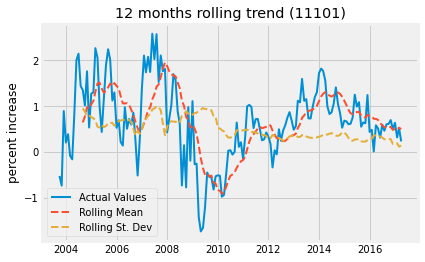

In [15]:
plot_moving_avg(sel_df1[:-40], 12, zip_1)

In [16]:
run_dickyey_fuller(sel_df1[:-40], zip_1)

Null Rejected (p = 0.0375). 11101 time series is stationary


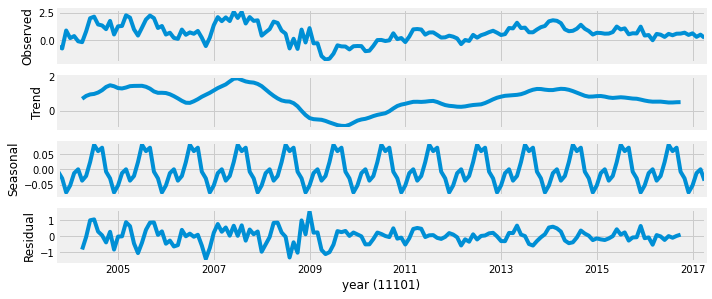

In [17]:
plot_decomposition(sel_df1[:-40], zip_1)

Time series is stationary but shows seasonality.

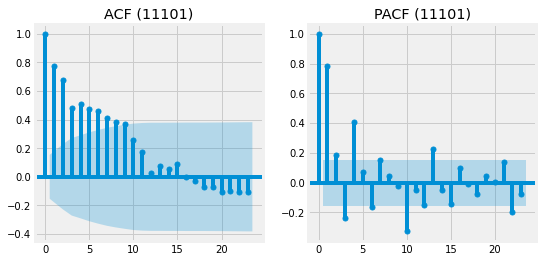

In [18]:
def_acf_pacf(sel_df1[:-40], zip_1)

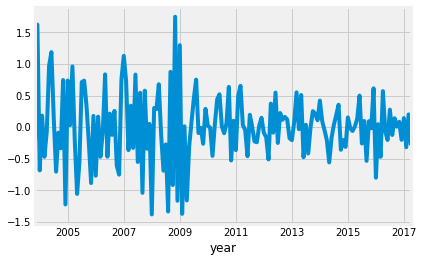

In [19]:
plot_basic(sel_df1[:-40].diff(1)[1:])

In [20]:
run_dickyey_fuller(sel_df1[:-40].diff(1)[1:], zip_1)

Null Rejected (p = 0.0041). 11101 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [ ]:
pdq, SPDQ = find_sarima_param(sel_df1[:-40])

In [22]:
sarima = SARIMAX(sel_df1[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model1 = sarima.fit()
print(sarima_model1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11101   No. Observations:                  163
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                 -61.502
Date:                            Mon, 11 Jan 2021   AIC                            131.003
Time:                                    21:07:17   BIC                            142.992
Sample:                                10-01-2003   HQIC                           135.874
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8314      0.066    -12.641      0.000      -0.960      -0.703
ma.L1          1.6271      0.257   

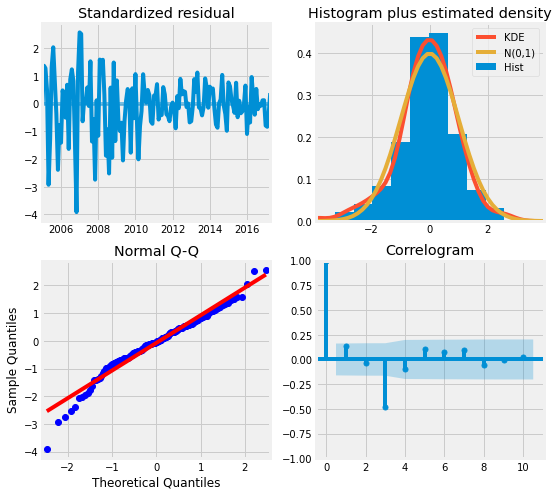

In [23]:
sarima_model1.plot_diagnostics(figsize = (8, 8))
plt.show()

For testing, we will calculate rmse based on rolling forecast.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


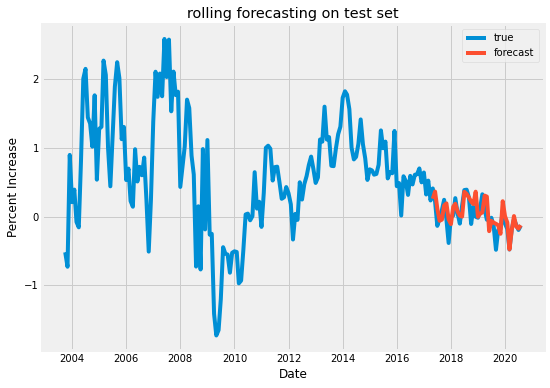

In [24]:
rmse_1 = test_RMSE(sel_df1, pdq, SPDQ)

### zipcode [2]
---

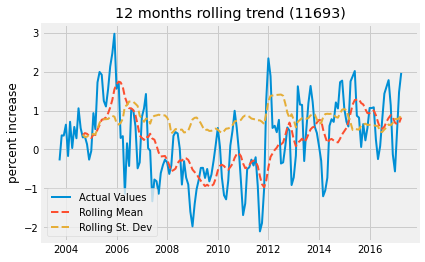

In [25]:
plot_moving_avg(sel_df2[:-40], 12, zip_2)

In [26]:
run_dickyey_fuller(sel_df2[:-40], zip_2)

Failed to reject the null (p = 0.4819). 11693 time series is not stationary


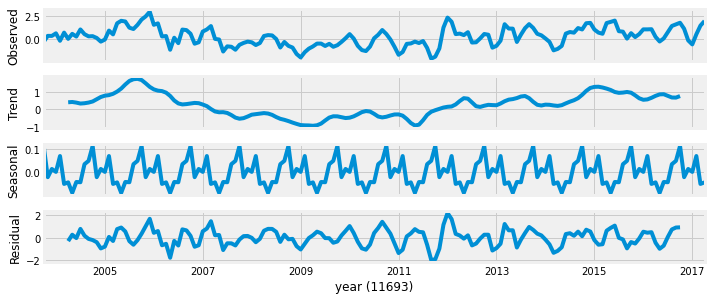

In [27]:
plot_decomposition(sel_df2[:-40], zip_2)

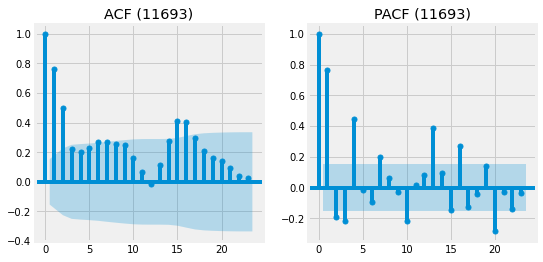

In [28]:
def_acf_pacf(sel_df2[:-40], zip_2)

Removing trend by differencing

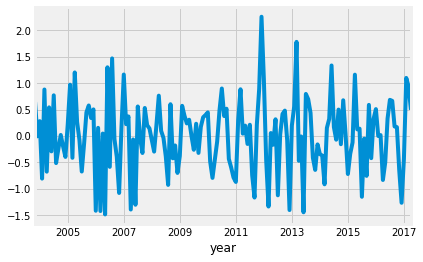

In [29]:
plot_basic(sel_df2[:-40].diff(1)[1:])

In [30]:
run_dickyey_fuller(sel_df2[:-40].diff(1)[1:], zip_2)

Null Rejected (p = 0.0). 11693 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [31]:
pdq, SPDQ = find_sarima_param(sel_df2[:-40])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq: (0, 1, 0), PDQS: (0, 0, 1, 12) - AIC: 251.38


In [32]:
sarima = SARIMAX(sel_df2[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model2 = sarima.fit()
print(sarima_model2.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11693   No. Observations:                  163
Model:             SARIMAX(0, 1, 0)x(0, 0, 1, 12)   Log Likelihood                -119.548
Date:                            Mon, 11 Jan 2021   AIC                            243.096
Time:                                    21:08:04   BIC                            249.104
Sample:                                10-01-2003   HQIC                           245.537
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -1.0000    511.854     -0.002      0.998   -1004.216    1002.216
sigma2         0.2374    121.503   

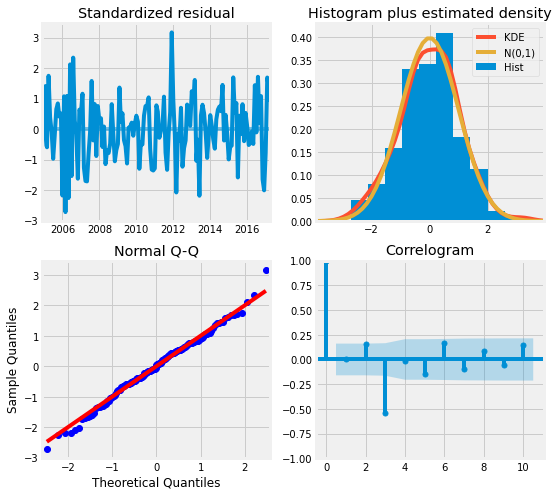

In [33]:
sarima_model2.plot_diagnostics(figsize = (8, 8))
plt.show()

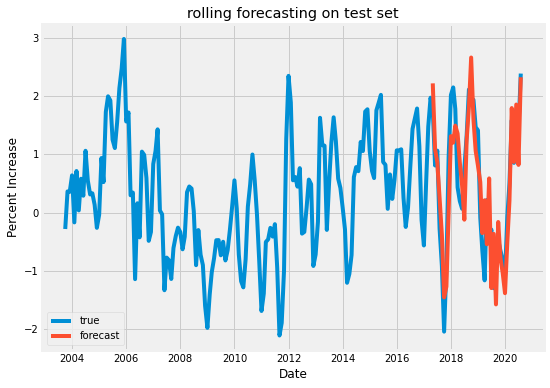

In [34]:
rmse_2 = test_RMSE(sel_df2, pdq, SPDQ)

### zipcode [3]
---

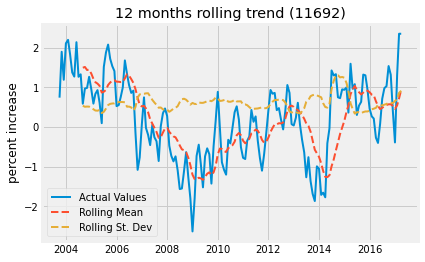

In [35]:
plot_moving_avg(sel_df3[:-40], 12, zip_3)

In [36]:
run_dickyey_fuller(sel_df3[:-40], zip_3)

Failed to reject the null (p = 0.2375). 11692 time series is not stationary


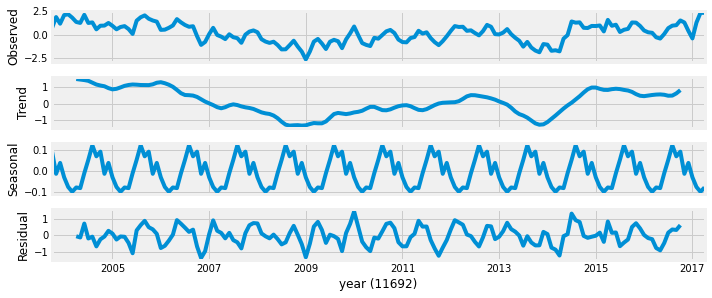

In [37]:
plot_decomposition(sel_df3[:-40], zip_3)

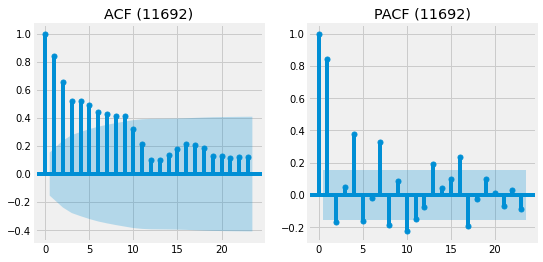

In [38]:
def_acf_pacf(sel_df3[:-40], zip_3)

Removing trend by differencing

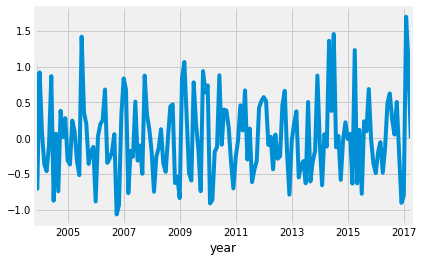

In [39]:
plot_basic(sel_df3[:-40].diff(1)[1:])

In [40]:
run_dickyey_fuller(sel_df3[:-40].diff(1)[1:], zip_3)

Null Rejected (p = 0.0). 11692 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [41]:
pdq, SPDQ = find_sarima_param(sel_df3[:-40])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


pdq: (0, 1, 0), PDQS: (0, 0, 1, 12) - AIC: 189.76


In [42]:
sarima = SARIMAX(sel_df3[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model3 = sarima.fit()
print(sarima_model3.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11692   No. Observations:                  163
Model:             SARIMAX(0, 1, 0)x(0, 0, 1, 12)   Log Likelihood                 -88.324
Date:                            Mon, 11 Jan 2021   AIC                            180.647
Time:                                    21:08:41   BIC                            186.655
Sample:                                10-01-2003   HQIC                           183.088
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -1.0000   1217.987     -0.001      0.999   -2388.212    2386.212
sigma2         0.1561    190.136   

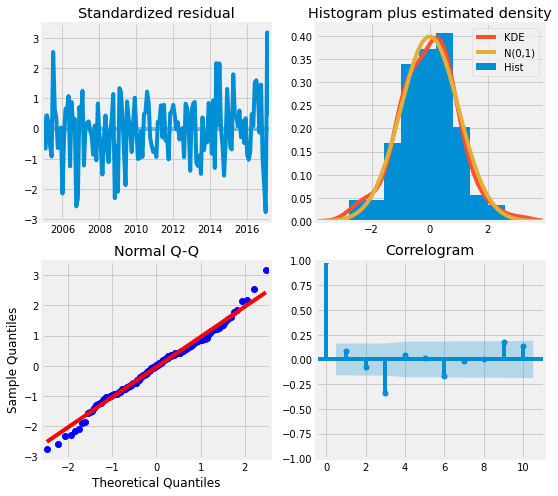

In [43]:
sarima_model3.plot_diagnostics(figsize = (8, 8))
plt.show()

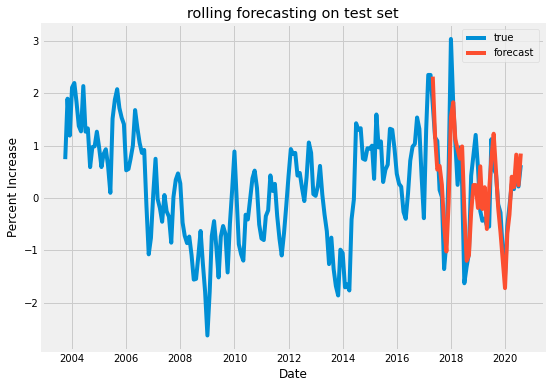

In [44]:
rmse_3= test_RMSE(sel_df3, pdq, SPDQ)

### zipcode [4]
---

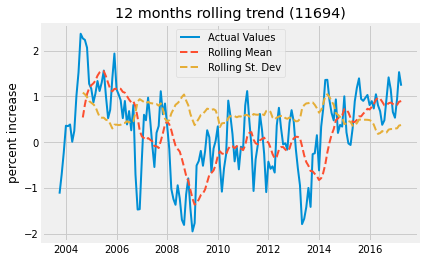

In [45]:
plot_moving_avg(sel_df4[:-40], 12, zip_4)

In [46]:
run_dickyey_fuller(sel_df4[:-40], zip_4)

Failed to reject the null (p = 0.5424). 11694 time series is not stationary


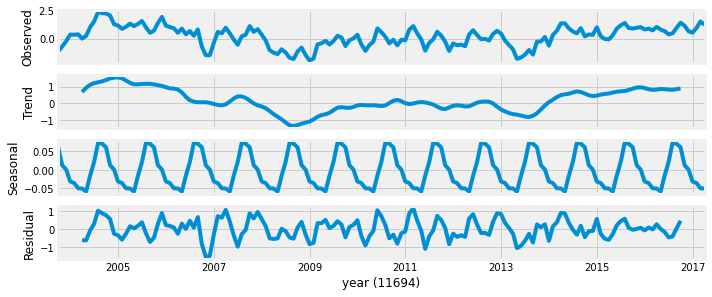

In [47]:
plot_decomposition(sel_df4[:-40], zip_4)

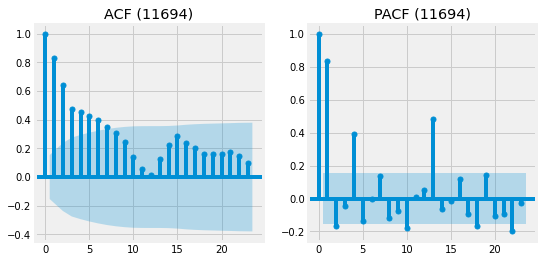

In [48]:
def_acf_pacf(sel_df4[:-40], zip_4)

Removing trend by differencing

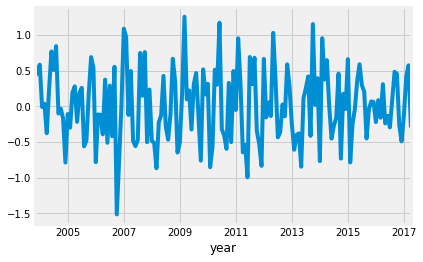

In [49]:
plot_basic(sel_df4[:-40].diff(1)[1:])

In [50]:
run_dickyey_fuller(sel_df4[:-40].diff(1)[1:], zip_4)

Null Rejected (p = 0.0). 11694 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [51]:
pdq, SPDQ = find_sarima_param(sel_df4[:-40])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


pdq: (0, 1, 0), PDQS: (1, 0, 1, 12) - AIC: 131.6


In [52]:
sarima = SARIMAX(sel_df4[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model4 = sarima.fit()
print(sarima_model4.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11694   No. Observations:                  163
Model:             SARIMAX(0, 1, 0)x(1, 0, 1, 12)   Log Likelihood                 -57.215
Date:                            Mon, 11 Jan 2021   AIC                            120.430
Time:                                    21:09:20   BIC                            129.442
Sample:                                10-01-2003   HQIC                           124.092
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2496      0.103     -2.423      0.015      -0.451      -0.048
ma.S.L12      -1.0000   2603.919   

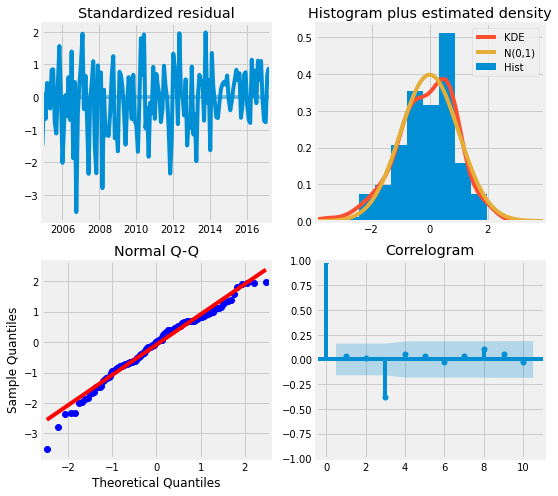

In [53]:
sarima_model4.plot_diagnostics(figsize = (8, 8))
plt.show()

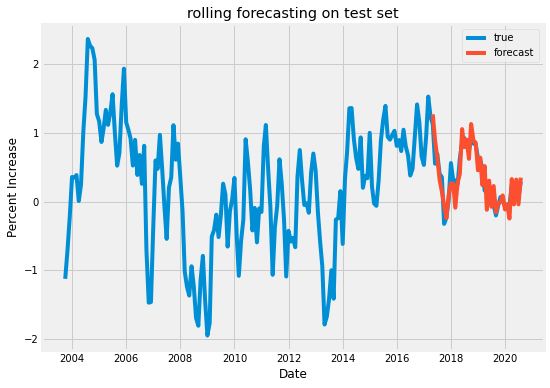

In [54]:
rmse_4 = test_RMSE(sel_df4, pdq, SPDQ)

### zipcode [5]
---

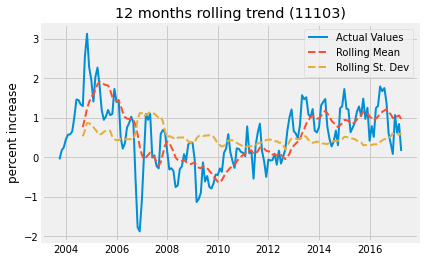

In [55]:
plot_moving_avg(sel_df5[:-40], 12, zip_5)

In [56]:
run_dickyey_fuller(sel_df5[:-40], zip_5)

Failed to reject the null (p = 0.1297). 11103 time series is not stationary


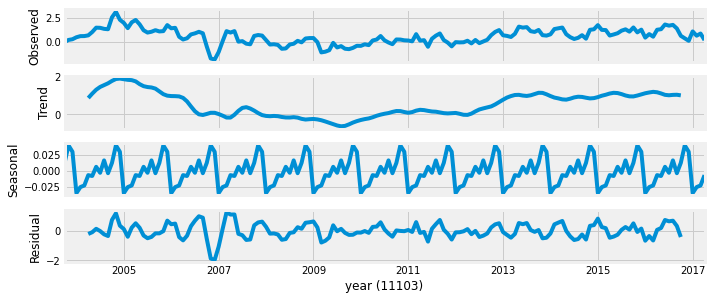

In [57]:
plot_decomposition(sel_df5[:-40], zip_5)

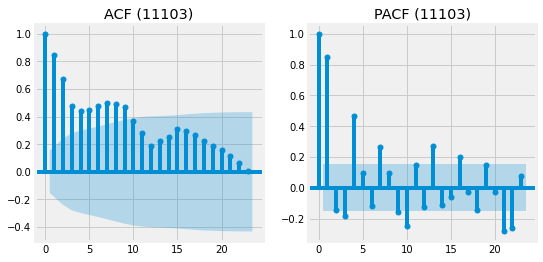

In [58]:
def_acf_pacf(sel_df5[:-40], zip_5)

Removing trend by differencing

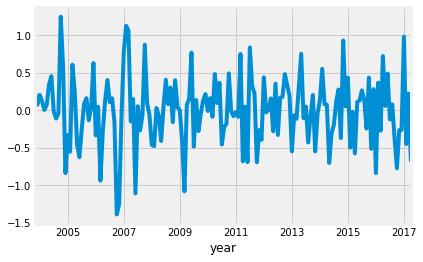

In [59]:
plot_basic(sel_df5[:-40].diff(1)[1:])

In [60]:
run_dickyey_fuller(sel_df5[:-40].diff(1)[1:], zip_5)

Null Rejected (p = 0.0001). 11103 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [61]:
pdq, SPDQ = find_sarima_param(sel_df5[:-40])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


pdq: (1, 1, 0), PDQS: (1, 0, 1, 12) - AIC: 102.54


In [62]:
sarima = SARIMAX(sel_df5[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model5 = sarima.fit()
print(sarima_model5.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11103   No. Observations:                  163
Model:             SARIMAX(1, 1, 0)x(1, 0, 1, 12)   Log Likelihood                 -45.679
Date:                            Mon, 11 Jan 2021   AIC                             99.358
Time:                                    21:10:03   BIC                            111.374
Sample:                                10-01-2003   HQIC                           104.240
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1374      0.066      2.079      0.038       0.008       0.267
ar.S.L12      -0.2144      0.075   

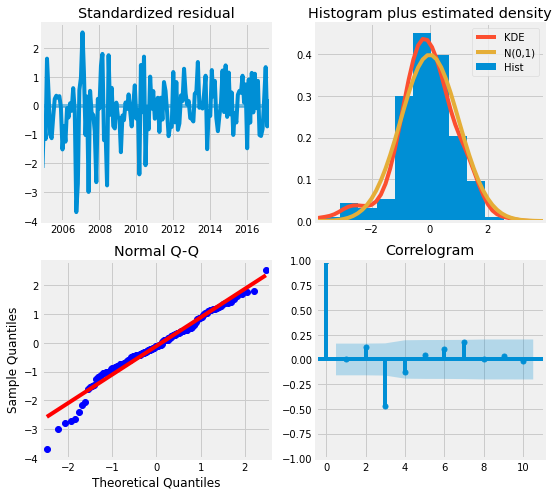

In [63]:
sarima_model5.plot_diagnostics(figsize = (8, 8))
plt.show()

In [65]:
rmse_5 = test_RMSE(sel_df5, pdq, SPDQ)

## SARIMA Total RMSE

In [ ]:
results['SARIMA'] = [rmse_1, rmse_2, rmse_3, rmse_4, rmse_5]

# Facebook Prophet
Now I will run the similar step using Facebook Prophet.

In [66]:
sel_df1 = sel_df1.reset_index()

In [67]:
fbp_rmse_1, forecast, model = fb_prophet_forecast(sel_df1)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


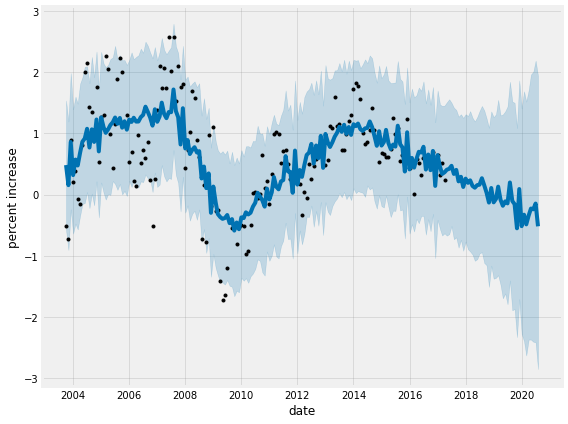

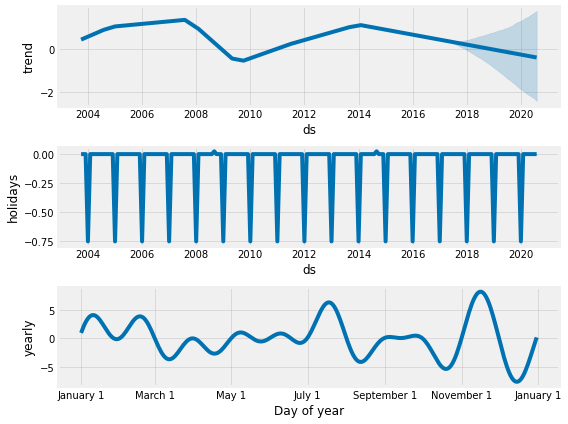

In [68]:
fbp_plot(forecast, model)

In [69]:
sel_df2 = sel_df2.reset_index()

In [70]:
fbp_rmse_2, forecast, model = fb_prophet_forecast(sel_df2)

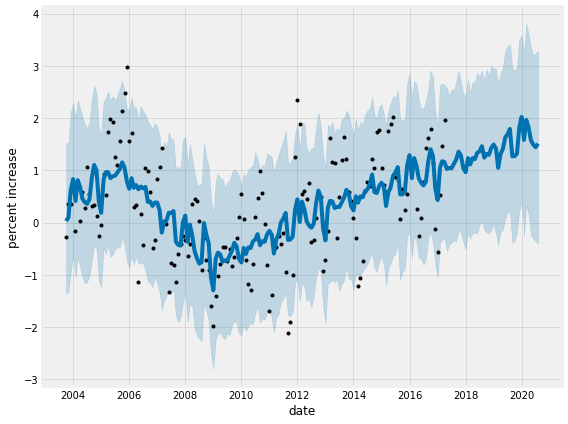

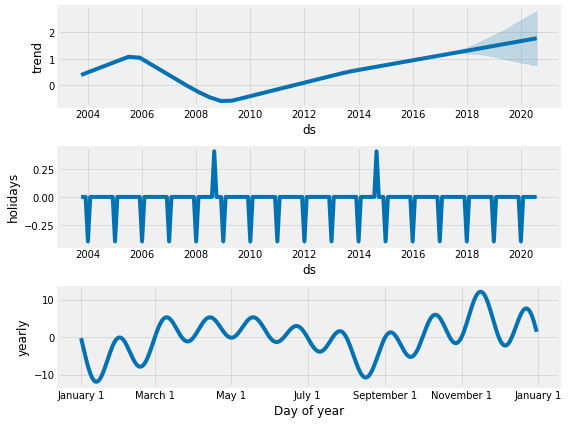

In [71]:
fbp_plot(forecast, model)

In [72]:
sel_df3 = sel_df3.reset_index()

In [73]:
fbp_rmse_3, forecast, model = fb_prophet_forecast(sel_df3)

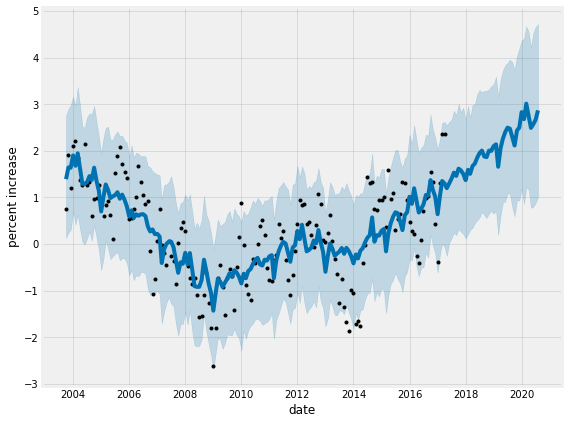

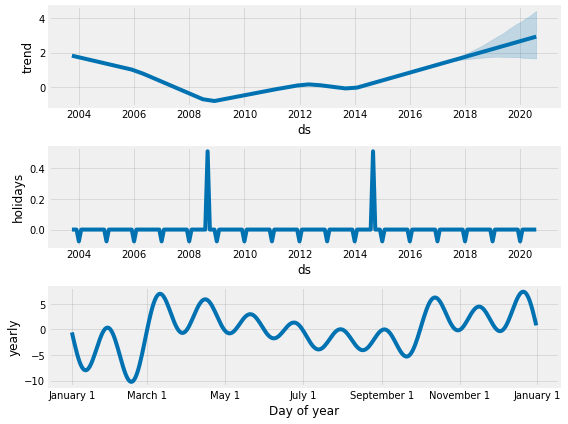

In [74]:
fbp_plot(forecast, model)

In [75]:
sel_df4 = sel_df4.reset_index()

In [76]:
fbp_rmse_4, forecast, model = fb_prophet_forecast(sel_df4)

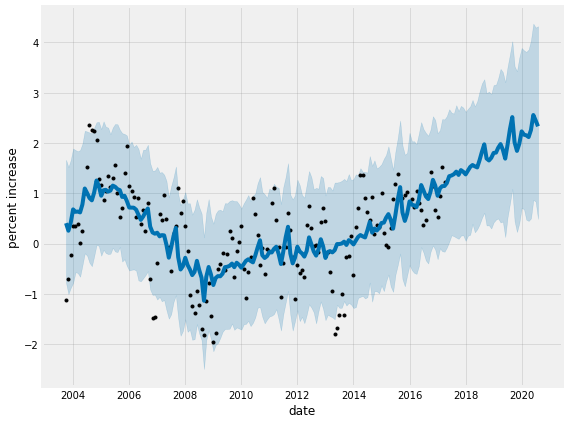

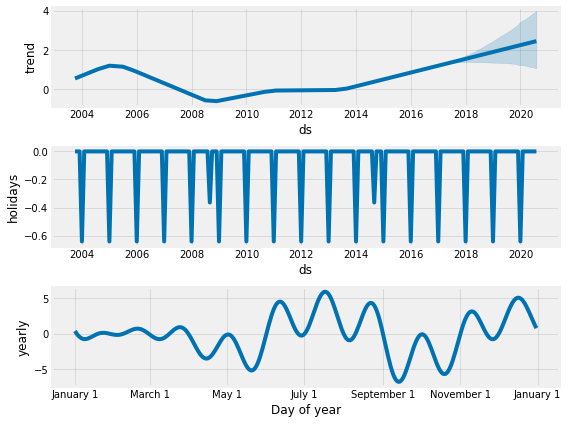

In [77]:
fbp_plot(forecast, model)

In [78]:
sel_df5 = sel_df5.reset_index()

In [79]:
fbp_rmse_5, forecast, model = fb_prophet_forecast(sel_df5)

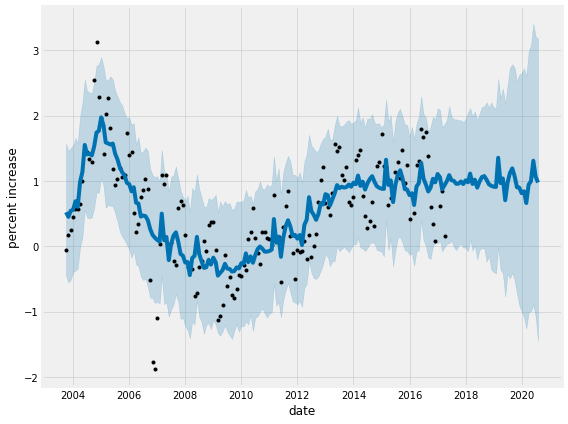

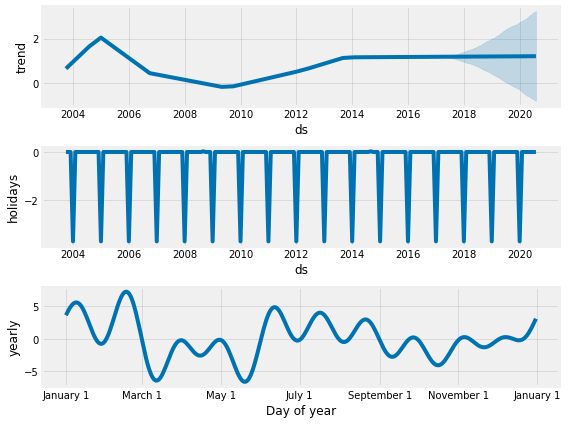

In [80]:
fbp_plot(forecast, model)

## FB Prophet total RMSE

In [81]:
results['FB_Prophet'] = [fbp_rmse_1, fbp_rmse_2, fbp_rmse_3, fbp_rmse_4, fbp_rmse_5]

In [82]:
results.sum()

baseline        2.406434
historic_avg    3.479188
FB_Prophet      6.411532
dtype: float64

It seems like generally SARIMA is performing better. Let's try the deep learning method now.

# LSTM
I'll use LSTM to do sequence prediction. How it works is that we break each time stamp with input of all observation to that point and output of the following sequence and feed into the LSTM architecture which predicts for the immediately following number. I'll set up a few functions to run them, which will be imported here just like what I did above.

In [83]:
from SCRIPT.lstm_tools import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [84]:
steps = 3

### Zipcode 1

In [85]:
sel_df1 = sel_df1.set_index('index')

In [86]:
# train/test split
trdf1 = sel_df1[:-40]
tedf1 = sel_df1[-(40+steps):]

In [87]:
inputs, outputs = sequence_generator(trdf1.iloc[:, 0], steps = steps)
test_inputs, test_outputs = sequence_generator(tedf1.iloc[:, 0], steps = steps)

In [127]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD

In [206]:
# LSTM architecture
clear_session()
model = Sequential()
model.add(LSTM(64, activation='relu', 
               input_shape=(steps, 1),
              return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))
#model.add(LSTM(64, activation = 'relu',return_sequences = True))
model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))

#lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * (10**(epoch / 20)))

model.compile(optimizer=Adam(lr=1e-3), 
              loss=Huber(), 
              metrics = ['mae'])

history = model.fit(inputs, outputs, epochs = 100, verbose = 0) #, callbacks = [lr_schedule])

In [198]:
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 30])

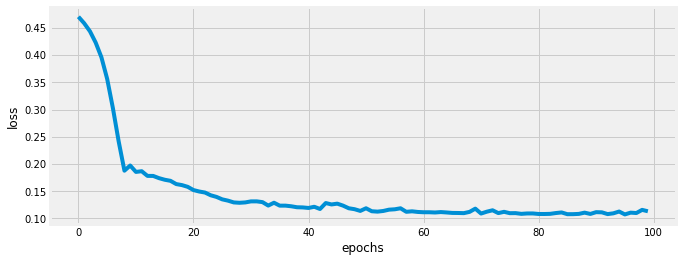

In [207]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

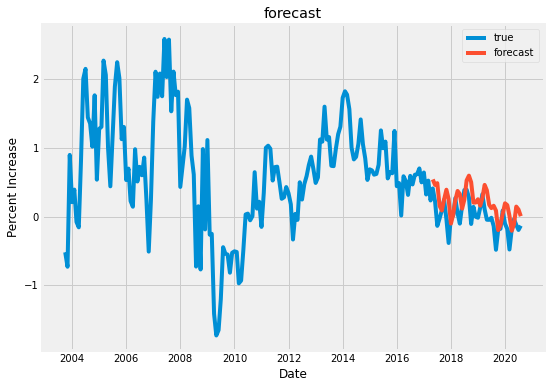

In [208]:
pred = model.predict(test_inputs)
rmse1 = show_RMSE(sel_df1, test_outputs, pred)

In [209]:
rmse1

0.2933126722845172

In [91]:
rmse1

0.23732527324353167

### Zipcode 2

In [ ]:
sel_df2 = sel_df2.set_index('index')

In [ ]:
# train/test split
trdf2 = sel_df2[:-40]
tedf2 = sel_df2[-(40+steps):]

In [ ]:
inputs, outputs = sequence_generator(trdf2.iloc[:, 0], steps = steps)
test_inputs, test_outputs = sequence_generator(tedf2.iloc[:, 0], steps = steps)

In [ ]:
# LSTM architecture
model = Sequential()
model.add(LSTM(64, activation='relu', 
               input_shape=(steps, 1),
              return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))

model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mse')
history = model.fit(inputs, outputs, epochs = 100, verbose = 0)

In [ ]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [ ]:
pred = model.predict(test_inputs)
rmse2 = show_RMSE(sel_df2, test_outputs, pred)

### Zipcode 3

In [ ]:
sel_df3 = sel_df3.set_index('index')

In [ ]:
# train/test split
trdf3 = sel_df3[:-40]
tedf3 = sel_df3[-(40+steps):]

In [ ]:
inputs, outputs = sequence_generator(trdf3.iloc[:, 0], steps = steps)
test_inputs, test_outputs = sequence_generator(tedf3.iloc[:, 0], steps = steps)

In [ ]:
# LSTM architecture
model = Sequential()
model.add(LSTM(64, activation='relu', 
               input_shape=(steps, 1),
              return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))

model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mse')
history = model.fit(inputs, outputs, epochs = 100, verbose = 0)

In [ ]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [ ]:
pred = model.predict(test_inputs)
rmse3 = show_RMSE(sel_df3, test_outputs, pred)

### Zipcode 4

In [ ]:
sel_df4 = sel_df4.set_index('index')

In [ ]:
# train/test split
trdf4 = sel_df4[:-40]
tedf4 = sel_df4[-(40+steps):]

In [ ]:
inputs, outputs = sequence_generator(trdf4.iloc[:, 0], steps = steps)
test_inputs, test_outputs = sequence_generator(tedf4.iloc[:, 0], steps = steps)

In [ ]:
# LSTM architecture
model = Sequential()
model.add(LSTM(64, activation='relu', 
               input_shape=(steps, 1),
              return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))

model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mse')
history = model.fit(inputs, outputs, epochs = 100, verbose = 0)

In [ ]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [ ]:
pred = model.predict(test_inputs)
rmse4 = show_RMSE(sel_df4, test_outputs, pred)

### Zipcode 5

In [ ]:
sel_df5 = sel_df5.set_index('index')

In [ ]:
# train/test split
trdf5 = sel_df5[:-40]
tedf5 = sel_df5[-(40+steps):]

In [ ]:
inputs, outputs = sequence_generator(trdf5.iloc[:, 0], steps = steps)
test_inputs, test_outputs = sequence_generator(tedf5.iloc[:, 0], steps = steps)

In [ ]:
# LSTM architecture
model = Sequential()
model.add(LSTM(64, activation='relu', 
               input_shape=(steps, 1),
              return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))
model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mse')
history = model.fit(inputs, outputs, epochs = 100, verbose = 0)

In [ ]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [ ]:
pred = model.predict(test_inputs)
rmse5 = show_RMSE(sel_df5, test_outputs, pred)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="lstm_arch.png", 
           show_shapes=True)

### Total LSTM


In [ ]:
results['LSTM'] = [rmse1, rmse2, rmse3, rmse4, rmse5]

In [ ]:
results.sum()

SARIMA still tops the performance.

In [ ]:
results